<div align='center'><font size='20'>气动数据库的建立</font></div>
<div align='center'><font size='5'>飞行仿真原理大作业</font></div>

<div align='center'><font size='2'> (按学号排列)  周长威 包晨宇 吴哲铭 胡天辰 孙赵轩</font></div>

---

[toc]

0. 项目简介
1. 气动曲线图像数据读取的研究
2. 与Sqlite3数据库的交互访问
3. 离散数据点的插值连续化分析
4. 打包模块实例展示

---

---

# 0.项目简介

在飞行仿真中，为了达到仿真效果与真机一致，需要用到大量的气动参数。但是受制于仿真的成本，不可能在现实生活中客观地造出与实际飞机一致的模型，并用传感器实时获取气动参数——因此将已经用实验获取的气动参数，存入数据库中，在仿真时实时访问得到相应的输入输出结果是一个较好的处理方法。

但由于现役飞机大部分气动参数来源于国外，且一些较老的飞机气动参数是由曲线图给出的。如下图为地面效应系数与飞行马赫数关系曲线图： 

<div align="center"><img src="https://cdn.jsdelivr.net/gh/bcynuaa/learning@main/project/Flight%20Simulation/homework/GroundEffectK.png" width=40%></div>

其曲线图具有如下不便于读取的特点：

- 给出的曲线图不能直接化成离散数据点
- 给出的曲线图往往是影印的，数据图像模糊
- 影印版本的数据在扫描时有旋转、翘曲的畸变，使得数据点的对应容易出现问题
- 一张曲线图上有多族曲线，难以分辨



针对上述问题，我们小组尽力尝试了一些算法，能够解决一些气动参数图线读取问题。整个工作流程大致如下：

1. 从某一给定的曲线图上，将曲线读取，并化成两行对应的离散数据点$x,y$
2. 与Sqlite3建立访问，将上述的离散数据点$x,y$存储入数据库中并保存
3. 建立函数库$y=f(x)$，在调用该曲线的对应函数式$f$时，读取数据库中已有的$x,y$数据，并给出输入值$x_{in}$的插值输出值

因而整个项目共有三个部分:

1. 气动曲线图像数据读取的研究
2. 与Sqlite3数据库的交互访问
3. 离散数据点的插值连续化分析

下面我们组将对于我们编写的函数与流程进行报告与分析，并在最后给第4部分将做好的函数库用以展示实例。

---

---

# 1. 气动曲线图像数据读取的研究

第一部分的输入(input)为：
- 图片
- 人工从曲线上读取的参数

第一部分的输出(output)为：
- 一组$x,y$对应的离散数据点


---

## 1.1. 理论分析

---

### 1.1.1. 图像预处理

图片的数据往往是一个$3\times m \times n$的矩阵，其中3表示的是图像的RGB颜色，m规定为图像的纵向行数，n规定为图像的横向列数。例如我们用opencv读取一张经典图片lena图，并显示它的尺寸信息：

<div align="center"><img src="https://cdn.jsdelivr.net/gh/bcynuaa/learning@main/project/Flight%20Simulation/homework/lena.jpg" width=80%></div>

(其中opencv是一个跨平台图像处理工具，其在python中的安装可以在bash中输入以下命令进行安装)：
```bash
pip install opencv-python
```

或者用conda命令：
```bash
conda install opencv-python
```

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

size of this picture is:  (810, 1440, 3) 
 origin picture:


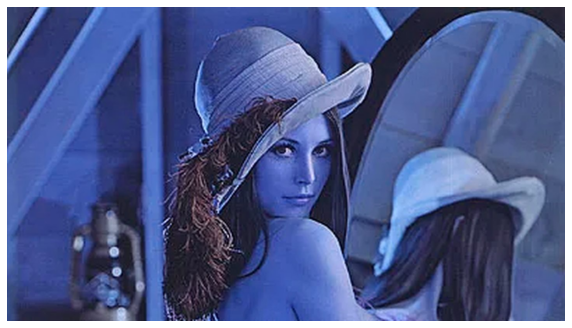

In [2]:
pic = cv.imread('lena.jpg') #利用opencv读取图像
mat = np.array(pic) #数组化
print('size of this picture is: ',mat.shape,'\n origin picture:')
plt.figure(figsize = (10,6))
plt.imshow(mat)
plt.axis('off')
plt.show()

可见这个图片是一个三通道的$810\times 1440$的三维数组，不是很方便处理。但是在opencv中有一个处理“图像灰度化”，可以将一个三维RGB数组投射到灰度值上，形成一个纯粹的$m\times n$矩阵,并且这个矩阵中存储的数值为0(黑)到255(白)：

size of the gray picture is :  (810, 1440) 
 gray pic :


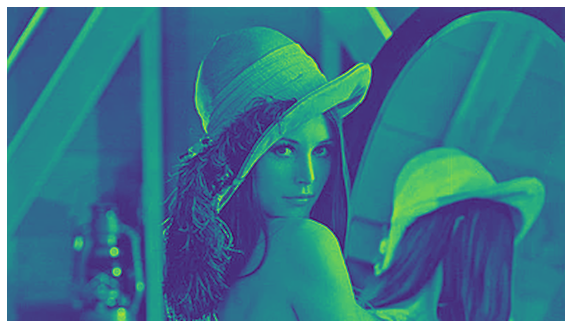

[[ 78  78  78 ...  51  51  51]
 [ 78  78  78 ...  51  51  51]
 [ 78  78  78 ...  51  51  51]
 ...
 [ 88  88  88 ...  95  96  97]
 [ 89  88  87 ...  99 100 100]
 [ 89  88  87 ...  99 100 100]]


In [3]:
gray = cv.cvtColor(pic , cv.COLOR_BGR2GRAY) #灰度化
gray = np.array(gray)
print('size of the gray picture is : ',gray.shape,'\n gray pic :')
plt.figure(figsize = (10,6))
plt.imshow(gray)
plt.axis('off')
plt.show()
print(gray)

此时容易发现每个像素点对应一个灰度值，为了统一各点的值，可以将其二值化进行处理，化成仅有两个值的情形：

binary pic :


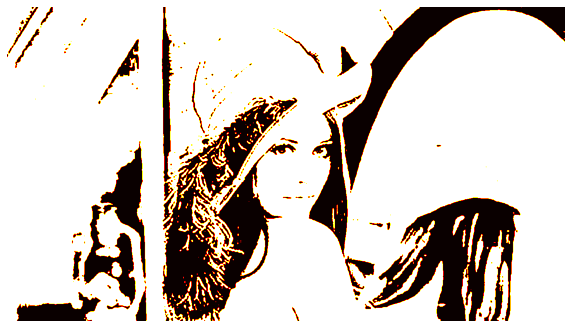

[[110 110 110 ...   0   0   0]
 [110 110 110 ...   0   0   0]
 [110 110 110 ...   0   0   0]
 ...
 [110 110 110 ... 110 110 110]
 [110 110 110 ... 110 110 110]
 [110 110 110 ... 110 110 110]]


In [4]:
retval , binary = cv.threshold(gray,60,110,cv.THRESH_BINARY) #二值化
binary = np.array(binary)
print('binary pic :')
plt.figure(figsize = (10,6))
plt.imshow(binary,cmap=plt.cm.hot)
plt.axis("off")
plt.show()
print(binary)

当然事实上，我们习惯有像素点(黑)的地方设置为1，空白的地方设置为0，因此编写一个可控的二值化函数：其中mat为传入的灰度矩阵，up为默认为5的灰度筛选上限值，小于up认为为黑色像素点，置为1，否则认为没有像素点置为0:

In [5]:
#人工二值化，控制up为黑白分界点
def get_filter0(mat,up=5):
    M,N = np.shape(mat)
    filter0 = np.zeros([M,N])
    for j in range(M):
        for i in range(N):
            if mat[j][i] < up: #这里的5就为初始筛选值
                filter0[j][i] = 1 #有颜色的地方设置为1
                pass
            pass
        pass
    return filter0

my binary pic :


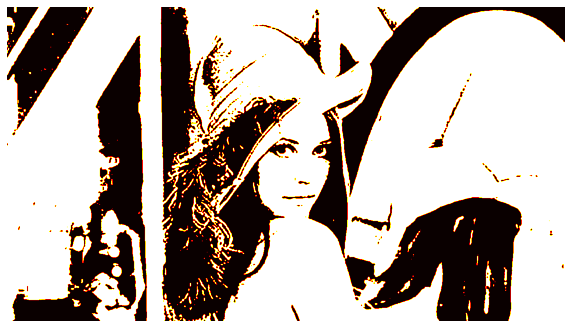

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
mybinary = get_filter0(gray,up=80)
print('my binary pic :')
plt.figure(figsize = (10,6))
plt.imshow(1 - mybinary,cmap=plt.cm.hot)
plt.axis("off")
plt.show()
print(mybinary)
del pic , gray , binary , retval , mat , mybinary

---

### 1.1.2. 像素点到到坐标的转换矩阵


在处理图像的时候，我们做出如下假设：

- 连续性假设：假设提取的曲线都是中间连续不断的，或者仅有少数的有限个间断点的曲线
- 平面假设：假设曲线图是完全二维的，也即再扫描过程中，扫描件为一个二维图形，没有因为书页的翘曲等因素向第三维发生翘曲、扭转等

对于平面的一个刚体，其有3个自由度。也就是定位一个平面位置，只需要确定三个点就可以了。我们现在应该有两个坐标：

1. 像素坐标：是由$i,j$定义的，每一个像素点所对应的坐标
2. 曲线坐标：是由$x,y$构成的，某一点在曲线坐标系下所对应的坐标位置

那么在平面上，必然会有两个坐标之间的一个转换关系，即：

$$
(x,y)=f(i,j)
$$

根据平面假设，这两个坐标之间的变换只会有：平移，旋转，仿射三种变换，在这样的假设下不难发现会有：

$$

\begin{bmatrix}
  x\\y
\end{bmatrix}

=

\begin{bmatrix}
  q_{11} & q_{21}\\
  q_{12} & q_{22}
\end{bmatrix}

\begin{bmatrix}
  i\\j
\end{bmatrix}

+

\begin{bmatrix}
  x_0\\y_0
\end{bmatrix}

$$

简记为：

$$
\boldsymbol{X}=\boldsymbol{Q} \boldsymbol{I} + \boldsymbol{X_0}
$$

这里把$\boldsymbol{Q}$成为转换矩阵，把$\boldsymbol{X_0}$称为转换零点坐标。如果点$(i_k,j_k)\rightarrow(x_k,y_k)$，那么有：

$$
\begin{cases}
i_k\cdot q_{11}+j_k\cdot q_{21}+x_0=x_k\\
i_k\cdot q_{12}+j_k\cdot q_{22}+x_0=y_k
\end{cases}
$$

因为刚体在平面上有三个自由度，所以需要$k=1,2,3$三组点到点的映射才能求解矩阵：

$$
\begin{cases}
(i_1,j_1)\rightarrow(x_1,y_1)\\
(i_2,j_2)\rightarrow(x_2,y_2)\\
(i_3,j_3)\rightarrow(x_3,y_3)
\end{cases}
$$

因此可以得到：

$$

\begin{bmatrix}
    i_1 & 0 & j_1 & 0 & 1 & 0\\
    0 & i_1 & 0 & j_1 & 0 & 1\\
    i_2 & 0 & j_2 & 0 & 1 & 0\\
    0 & i_2 & 0 & j_2 & 0 & 1\\
    i_3 & 0 & j_3 & 0 & 1 & 0\\
    0 & i_3 & 0 & j_3 & 0 & 1
\end{bmatrix}

\begin{bmatrix}
    q_{11}\\
    q_{12}\\
    q_{21}\\
    q_{22}\\
    x_0\\
    y_0
\end{bmatrix}

=

\begin{bmatrix}
    x_1\\
    y_2\\
    x_2\\
    y_2\\
    x_3\\
    y_3
\end{bmatrix}

\\
\downarrow
\\

\begin{bmatrix}
    q_{11}\\
    q_{12}\\
    q_{21}\\
    q_{22}\\
    x_0\\
    y_0
\end{bmatrix}

=

\begin{bmatrix}
    i_1 & 0 & j_1 & 0 & 1 & 0\\
    0 & i_1 & 0 & j_1 & 0 & 1\\
    i_2 & 0 & j_2 & 0 & 1 & 0\\
    0 & i_2 & 0 & j_2 & 0 & 1\\
    i_3 & 0 & j_3 & 0 & 1 & 0\\
    0 & i_3 & 0 & j_3 & 0 & 1
\end{bmatrix}
^{-1}

\begin{bmatrix}
    x_1\\
    y_1\\
    x_2\\
    y_2\\
    x_3\\
    y_3
\end{bmatrix}

$$

观察后容易发现可以化简,令：
$$

A=

\begin{bmatrix}
    i_1 & j_1 & 1\\
    i_2 & j_2 & 1\\
    i_3 & j_3 & 1
\end{bmatrix}

$$

则将上式化归为：
$$
A

\begin{bmatrix}
    q_{11}\\
    q_{21}\\
    x_0 
\end{bmatrix}

=

\begin{bmatrix}
    x_1\\
    x_2\\
    x_3 
\end{bmatrix}

\\
\\

A

\begin{bmatrix}
    q_{12}\\
    q_{22}\\
    y_0 
\end{bmatrix}

=
\begin{bmatrix}
    y_1\\
    y_2\\
    y_3 
\end{bmatrix}

$$

所以不难发现:

$$

\begin{bmatrix}
    q_{11}\\
    q_{21}\\
    x_0\\
    q_{12}\\
    q_{22}\\
    y_0
\end{bmatrix}

=

\begin{bmatrix}
    A^{-1} & 0\\
    0 & A^{-1}
\end{bmatrix}

\begin{bmatrix}
    x_1\\
    x_2\\
    x_3\\
    y_1\\
    y_2\\
    y_3
\end{bmatrix}

$$

于是在给定了三组点到点的映射情形下，可以解的此六个未知数，从而得到转换矩阵$Q$和转换零点坐标$X_0$。不难发现，要保证$A$矩阵非奇异可逆，这三个点的选取也有要求；而且对于最终的转换关系，这三个点也有需求。因此姑且对这三个对应关系点的选取做如下要求：

- 选取的三个点不能在一条直线上，以保证$A$矩阵的非奇异性、可逆性
- 选取的三个点距离尽可能远，以更好的代表整幅画面的旋转、平移、仿射程度
- 一般选取坐标原点、坐标轴两端点作为三组对应的选取点

以下是转换矩阵与转换零点坐标的求解函数：

In [7]:
#转换矩阵函数，给定ij位置以及对应的xy坐标，返回转换矩阵q和转换零点坐标xy0
def Trans(ij,xy):
    i1 , j1 , i2 , j2 , i3 , j3 = ij
    x1 , y1 , x2 , y2 , x3 , y3 = xy
    A=np.array([
        [i1 , j1 , 1],
        [i2 , j2 , 1],
        [i3 , j3 , 1]
    ])
    invA = np.linalg.inv(A)
    q11,q21,x0 = invA.dot(np.array([x1 , x2 , x3]))
    q12,q22,y0 = invA.dot(np.array([y1 , y2 , y3]))
    q=np.array([
        [q11 , q21],
        [q12 , q22]
    ])
    xy0 = np.array([[x0] , [y0]])
    return q , xy0
    pass

---

## 1.2. 原点获取

我们还是以之前的“地效系数K-M关系”曲线图为例子：

<div align="center"><img src="https://cdn.jsdelivr.net/gh/bcynuaa/learning@main/project/Flight%20Simulation/homework/GroundEffectK.png" width="40%"></div>

按照之前的步骤我们进行一下预处理：

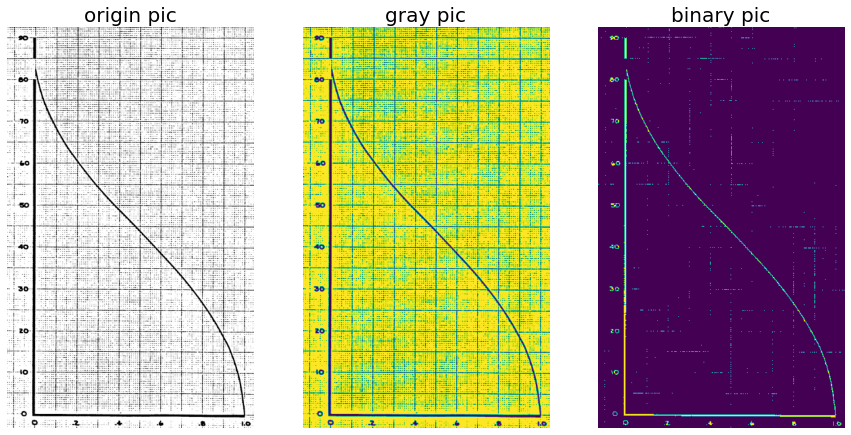

In [8]:
pic = cv.imread('GroundEffectK.png') #读取图片
plt.figure(figsize = (15,9))
plt.subplot(1,3,1)
plt.imshow(pic)
plt.axis('off')
plt.title('origin pic',fontsize = 20)

gray = cv.cvtColor(pic,cv.COLOR_BGR2GRAY) #灰度化
mat = np.array(gray)
plt.subplot(1,3,2)
plt.imshow(mat)
plt.axis('off')
plt.title('gray pic',fontsize = 20)

binary = get_filter0(mat , 4) #人工二值化
plt.subplot(1,3,3)
plt.imshow(binary)
plt.axis('off')
plt.title('binary pic',fontsize = 20)
plt.show()

要想获取原点坐标，有一个很朴素但有效的方法：

注意观察到原点有如下性质：

- 为两轴交点
- 一般而言扫描件图线是较为工整的，即使畸变，坐标轴所占据的像素宽度在三个左右

于是我们设计了一个算法将自动捕获在像素坐标系下的原点坐标$M_0,N_0$，其具体思路大致如下：

1. 新开一个矩阵Sum，其大小和二值化后的图像矩阵大小一致
2. 对于新开的矩阵Sum，其第 j 行第 i 列中填入某一值，该值计算方法如下
3. 将二值矩阵中 j-1、j、j+1行所有元素加起来，并加上，二值矩阵中 i-1、i、i+1列所有元素之和，填入Sum的 j 行 i 列
4. 搜寻Sum矩阵中最大值的位置，该位置 j , i 及对应的像素坐标系下的图线原点，记作 M0 ，N0

具体算法如下：

In [9]:
#自动筛选原点，传入灰度矩阵，返回M0，N0
def get0(mat):
    M,N = np.shape(mat)
    Sum=np.zeros([M , N])
    for j in range(1,M-1):
        for i in range(1,N-1):
            Sum[j][i] = 0
            Sum[j][i]+= mat[j-1].sum()
            Sum[j][i]+= mat[j].sum()
            Sum[j][i]+= mat[j+1].sum()
            Sum[j][i]+= mat.T[i-1].sum()
            Sum[j][i]+= mat.T[i].sum()
            Sum[j][i]+= mat.T[i+1].sum()
            pass
        pass
    pos = np.argmax(Sum)
    M0 = int(pos / N)
    N0 = pos-N*M0
    return M0 , N0

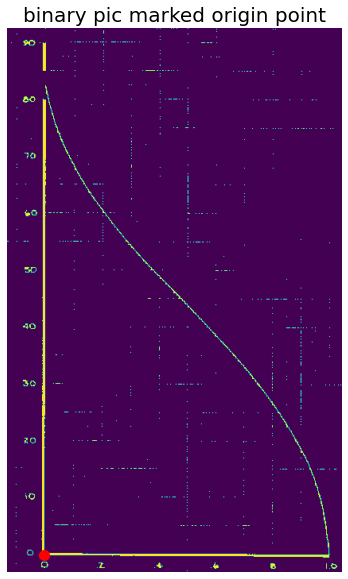

In [10]:
M0 , N0 = get0(binary)
plt.figure(figsize = (6,10))
plt.imshow(binary)
plt.axis('off')
plt.title('binary pic marked origin point' , fontsize = 20)
plt.scatter(N0 , M0 , s=100 , color='r')
plt.show()


可以发现效果还是挺好的，直接定位到了原点的位置。

---

---

## 1.3. 图像过滤

因为图片品质的问题，往往会遇到一些点不能被二值化过滤掉形成极为难看的斑点，也会干扰最终的取点操作步骤。就如同上述'binary pic marked origin point'图中所展示的那样，有很多“噪声”。

为了展示出这个效果，我们定义了下面这个函数用于像素点提取：

In [11]:
#提取点,将矩阵中所有的有效点位置坐标（i，j）提取并返回一个2*n的数组
def get_xiyj(mat):
    xi = []
    yj = []
    M , N = np.shape(mat)
    for j in range(M):
        for i in range(N):
            if mat[j][i] > 0:
                xi.append(i)
                yj.append(j)
                pass
            pass
        pass
    xi = np.array(xi)
    yj = np.array(yj)
    xiyj = np.c_[xi,yj]
    xiyj = xiyj.T
    return xiyj

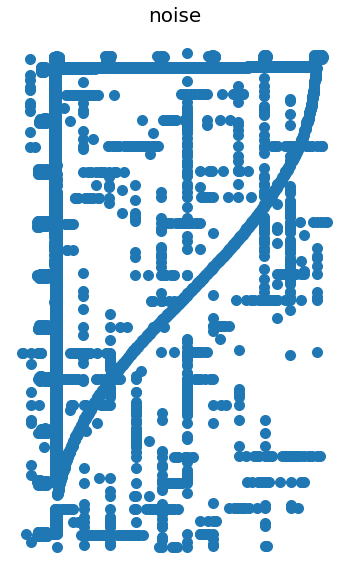

In [12]:
xiyj = get_xiyj(binary)
plt.figure(figsize = (6,10))
plt.scatter(xiyj[0] , xiyj[1],s = 100)
plt.axis('off')
plt.title('noise' , fontsize = 20)
plt.show()

容易发现整张图里面充斥着噪音，难以提取到我们所想要的曲线。所以这个时候我们需要进行“过滤操作”，把这些多余的“噪声点”过滤掉。为此我们设计了两个过滤算法，并用python代实现了，效果不错：

- 均值过滤
- 元胞自动机分拣过滤

---

---

### 1.3.1. 均值过滤(mean_filter)

均值过滤法的核心思想是建立在“连续性假设”上的，即认为整个提取的曲线是“连续不断，或者仅有少数有限个间断点的像素点集”。其算法思想和步骤如下：

- 新开一个与二值矩阵维数一致的矩阵，遍历二值矩阵，对新矩阵中某一个点 j , i 填入如下数字
- 将其周围八个格点中的所有值加起来，并加上自身得到一个值value
- 将value/9，和给定的上限limit(默认为0.34)作比较，小于则置新矩阵的 j,i 位为0，大于则置为1
- 最后得到新矩阵返回

其原理阐释如下，不妨假想从曲线上任意提取一点，并放大；假设最极限情况下，这条曲线的粗细只有一个像素点，那么其周围的情况大致如下：

$$
\begin{matrix}

\ddots \\
\dots & 0 & 0 & 1 & \dots \\
\dots & 0 & 1 & 0 & \dots \\
\dots & 1 & 0 & 0 &\dots \\
& & & &\ddots

\end{matrix}
$$

或者有又如：

$$
\begin{matrix}

\ddots \\
\dots & 0 & 0 & 1 & \dots \\
\dots & 1 & 1 & 0 & \dots \\
\dots & 0 & 0 & 0 &\dots \\
& & & &\ddots

\end{matrix}

\text{or}

\begin{matrix}

\ddots \\
\dots & 0 & 0 & 0 & \dots \\
\dots & 1 & 1 & 0 & \dots \\
\dots & 0 & 0 & 1 &\dots \\
& & & &\ddots

\end{matrix}

\text{or}

\begin{matrix}

\ddots \\
\dots & 1 & 0 & 0 & \dots \\
\dots & 0 & 1 & 0 & \dots \\
\dots & 0 & 0 & 1 &\dots \\
& & & &\ddots

\end{matrix}
$$

也就是说，只要“连续性假设”成立，理论上曲线上任意一点周边都至少应该两个格点，算上自己应该是三个格点。如果曲线线条更粗，甚至有可能达到4、5个格点以上，比如：

$$
\begin{matrix}

\ddots \\
\dots & 1 & 0 & 1 & \dots \\
\dots & 1 & 1 & 1 & \dots \\
\dots & 1 & 1 & 0 &\dots \\
& & & &\ddots

\end{matrix}
$$

总之，平均到每个格点之中，其自身和周围八个格点中的均值应该是≥0.33的，我们这里为了更挑剔一些，取0.34为默认的上限limit值。

然后我们将算法步骤编写成两个函数用于处理这个过滤方案，并形象地称之为“均值过滤”。

In [13]:
#获取九宫格均值矩阵，传入矩阵，用以均值筛选
def get_mean(mat):
    M , N = np.shape(mat)
    mean = np.zeros([M , N])
    for j in range(1,M-1):
        for i in range(1,N-1):
            tmp = 0
            tmp = mat[j-1][i-1] + mat[j-1][i] + mat[j-1][i+1]\
                + mat[j][i-1] + mat[j][i] + mat[j][i+1]\
                    + mat[j+1][i-1] + mat[j+1][i] + mat[j+1][i+1]
            mean[j][i] = tmp / 9
            pass
        pass
    return mean

#均值过滤，输入矩阵与均值限制limit，一般limit不低于0.34，返回过滤一步后的矩阵
def mean_filter(mat,limit=0.34): #均值过滤函数
    mean = get_mean(mat)
    M , N = np.shape(mat)
    for j in range(1,M-1):
        for i in range(1,N-1):
            if mean[j][i] < limit:
                mean[j][i] = 0
                pass
            else:
                mean[j][i] = 1
                pass
            pass
        pass
    return mean

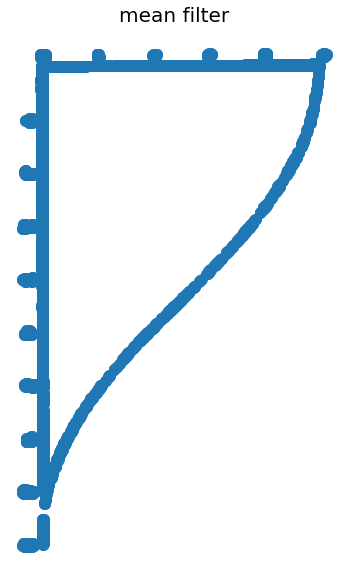

In [14]:
xiyj = get_xiyj(mean_filter(mean_filter(binary))) #运用了两次均值过滤法
plt.figure(figsize = (6,10))
plt.scatter(xiyj[0] , xiyj[1],s = 100)
plt.axis('off')
plt.title('mean filter' , fontsize = 20)
plt.show()


可以发现均值过滤的方法效果非常好，但是如果对于多条曲线过滤的话，效果如何呢？于是我们开创了一个新的算法：元胞自动机分拣算法。

---

### 1.3.2. 元胞自动分拣机过滤(CAfilter)

---

#### 1.3.2.1. 元胞自动机概述

元胞自动机(Cellular Automata)是一种时间、空间、状态都离散，空间相互作用和时间因果关系为局部的网格动力学模型，具有模拟复杂系统时空演化过程的能力。

不同于一般的动力学模型，元胞自动机不是由严格定义的物理方程或函数确定，而是用一系列模型构造的规则构成。凡是满足这些规则的模型都可以算作是元胞自动机模型。因此，元胞自动机是一类模型的总称，或者说是一个方法框架。其特点是时间、空间、状态都离散，每个变量只取有限多个状态，且其状态改变的规则在时间和空间上都是局部的。

其中最著名的元胞自动机当属Conway的生命游戏lifegame，其阐释如下：
- 平面上的一系列格点有‘生’、‘死’两个状态
- 当前状态下，该格子周围‘生’的格子超过3个，下一时刻该格子因为竞争激烈而‘死’；‘生’的格子数小于2个，也会因为资源太少而‘死’；个数为2个的时候，下一时刻细胞状态不变；若为3个，则会繁衍获‘生’
- 按照这样的‘规则’迭代，会有奇妙的结果出现；有些解是固定的，有些解是周期性的，还有些解则会运动影响到四周的格子生死

其lifegame的代码展示如下

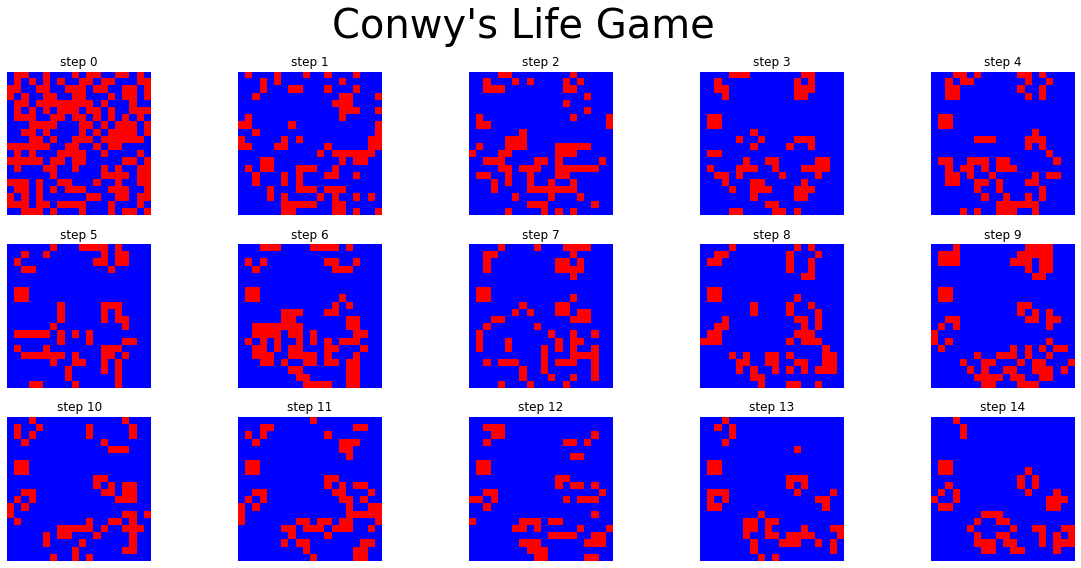

In [15]:
#定义生命游戏的迭代规则
def LifeGame(mat):
    [m,n] = mat.shape
    mat_next = np.zeros([m,n])
    mat_expand = np.zeros([m+2,n+2])
    mat_expand[0] = np.concatenate((np.array([mat[-1][-1]]),mat[-1],np.array([mat[-1][0]])))
    mat_expand[-1] = np.concatenate((np.array([mat[0][-1]]),mat[0],np.array([mat[0][0]])))
    for j in range(m):
        mat_expand[j+1] = np.concatenate((np.array([mat[j][-1]]),mat[j],np.array([mat[j][0]])))
        pass
    for j in range(m):
        for i in range(n):
            value_ji = mat_expand[j+1][i+1]
            value = mat_expand[j][i] + mat_expand[j][i+1] + mat_expand[j][i+2]\
                + mat_expand[j+1][i] + mat_expand[j+1][i+2]\
                    + mat_expand[j+2][i] + mat_expand[j+2][i+1] + mat_expand[j+2][i+2]
            if value == 2:
                mat_next[j][i] = value_ji
                pass
            elif value == 3:
                mat_next[j][i] = 1
                pass
            else:
                mat_next[j][i] = 0
                pass
            pass
        pass
    return mat_next
    pass

#随机展示一组
import random as rd
init = np.zeros([20,20])
[m,n] = init.shape
for j in range(m):
    for i in range(n):
        init[j][i] = rd.randint(0,1)
        pass
    pass
plt.figure(figsize = (20 , 9))
plt.suptitle("Conwy's Life Game",fontsize = 40)
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(init , cmap ='bwr')
    plt.axis('off')
    plt.title('step ' + str(i))
    init = LifeGame(init)
    pass
plt.show()
del init , m , n , i , j

后世的Mathematica创始人Wolfram对元胞自动机推崇有加，并用此处理了很多问题。除了在社会科学、计算机科学、物理学、数学和化工学等领域的运用，1983年的时候Wolfram将CA用于图像处理与模式识别之中。

---

#### 1.3.2.2. 元胞自动分拣机所处理的问题

在曲线读取的过程中，会遇到的问题例如：多组曲线的同时读取。比如下列这段代码所带来的问题：

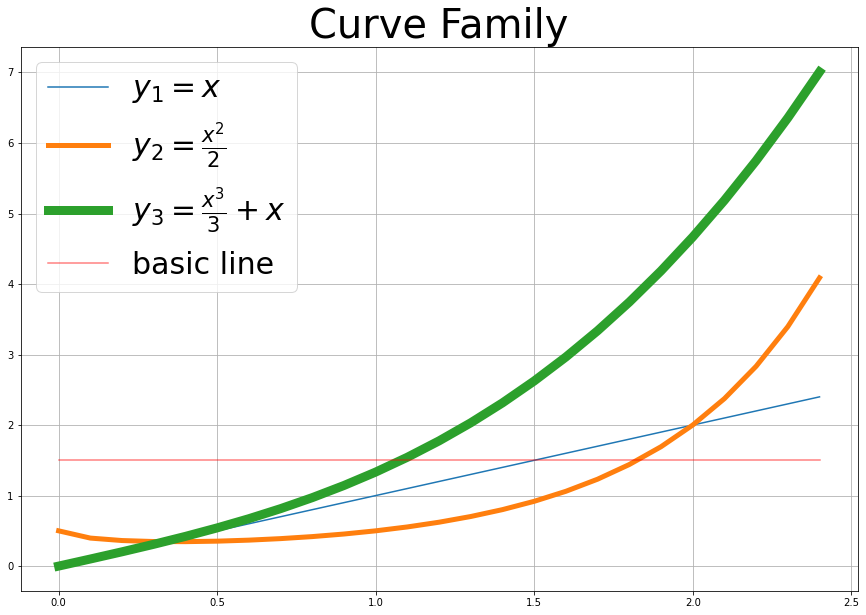

In [16]:
x = np.arange(0,2.5,0.1)
y = np.zeros([4 , x.size])
y[0] = x
y[1] = x**x/2
y[2] = x**3/3+x
y[3] = np.zeros(x.size) + 1.5
plt.figure(figsize = (15,10))
plt.plot(x,y[0] , label = '$y_1=x$')
plt.plot(x,y[1] , label = r'$y_2=\frac{x^2}{2}$' , linewidth = 5)
plt.plot(x,y[2] , label = r'$y_3=\frac{x^3}{3}+x$' , linewidth = 9)
plt.plot(x,y[3] , color = 'r' , alpha = 0.5 , label = 'basic line' )
plt.legend(prop = {'size':30})
plt.grid('True')
plt.title('Curve Family',fontsize = 40)
plt.show()
del x , y

不难发现，若一张曲线图上有三条曲线，那么任意在图中取一行“像素点”(即图中红色半透明线'basic line'所切成的)，与当前的三族曲线有相交的像素点。

但是**由于各条曲线粗细不同，每条相交的像素点个数是未知的**，不可能用人工的方法取筛选。因此我们设计了一定规则的元胞自动机完成下述任务：

- 扫描这一条basic line单像素线形成的像素带，分清各个像素
- 根据连续性假设，隶属于同一条曲线的像素点必然在这条像素带上连续，因此将这些聚集的像素点归拢到中心

具体来讲，假如说我有一条像素带上对应的像素点如下所示：

$$
\begin{matrix}
\dots & 0 & 1 & 1 & 1 & 0 & 0 & 0 
& 1 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 0 
& 0 & 0 & 1 & 0 & 0 & 1 & 1 & 0 & 0 & \dots
\end{matrix} 
$$

那么它一共有“6堆”的1，我所要做的是把每一堆归拢到自身**最中心**的位置上去，最终应该得到：

$$
\begin{matrix}
\dots & 0 & 0 & 1 & 0 & 0 & 0 & 0 
& 1 & 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 
& 0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & \dots
\end{matrix} 
$$

这是我们设计的元胞自动机所需要完成的任务——因为这个任务看起来像是在将各个类别“分开，挑拣”，于是我们把它命名为“元胞自动分拣机过滤算法”，其目的是对多组曲线进行“筛选、分开、像素细化”。

---

#### 1.3.3.3. 元胞自动分拣机的设计

仿照Conway生命游戏lifegame的算法设计，我们从单个的小细胞、小单元上分析，给出一个**一维元胞自动机**的迭代规则如下：

- 当$i$位为1，$i-1,i+1$位为0，则分拣完成，这是一个固定的像素点，下一时刻$i$位还为1
- 当$i$位为1，$i-1,i+1$位为1，则下一时刻$i$位还为1
- 当$i$位为1，$i-1$位为1，$i+1$位为0，则向前聚拢，下一时刻$i$位为0，$i-1$位为1
- 当$i$位为1，$i+1$位为1，$i-1$位为0，则向后聚拢，下一时刻$i$位为0，$i+1$位为1
- 当$i$位为0，下一时刻$i$位还位为0，为空隙，忽略不计

1. 对于
$$
\begin{matrix}
\dots & 0 & 1 & 0 & \dots
\end{matrix}
$$  
下一步迭代维持原样不动。

2. 对于：
$$
\begin{matrix}
\dots & 0 & 1 & 1 & 1 & 0 & \dots
\end{matrix}
$$
下一步迭代时，中间的'1'细胞前后均凋亡得到：
$$
\begin{matrix}
\dots & 0 & 0 & 1 & 0 & 0 & \dots
\end{matrix}
$$
实现了像素细化。

3. 对于:
$$
\begin{matrix}
\dots & 0 & 1 & 1 & 0 & \dots
\end{matrix}
$$
需要注意的是，上述规则是从右往左依次进行的，事实上在一步迭代以后会得到：
$$
\begin{matrix}
\dots & 0 & 1 & 0 & 0 & \dots
\end{matrix}
$$
完成了像素细化，至于总体上一个像素的偏差对于结果的影响忽略不计。

4. 而对于更加多像素的情形，则可以根据情形2，在多步迭代后化归为前三种情形。

上述规则下的元胞自动机**一定是有收敛解的**，也就是在有限次数后必然会稳定，于是我们将单步拓展至多步，判断是否已经收敛；若是则返回，否则继续迭代。判断方式为这一行像素点之和等于上一步迭代的像素点之和。

具体代码实现如下：

In [17]:
# 单步元胞自动拣选机作用，输入行向量处理
def CAiter(x):
    a = np.zeros(x.size)
    for i in range(1,x.size-1):
        if x[i] == 1 and x[i-1] == 0 and x[i+1] == 0:
            a[i] = 1
            pass
        elif x[i] == 1 and x[i-1] == 1 and x[i+1] == 0:
            a[i] = 0
            a[i-1] = 1
            pass
        elif x[i] == 1 and x[i-1] == 0 and x[i+1] == 1:
            a[i] = 0
            a[i+1] = 1
            pass
        elif x[i]*x[i-1]*x[i+1] == 1:
            a[i] = 1
            pass
        else:
            a[i] = 0
            pass
        pass
    return a
    pass

#多步元胞自动拣选机作用，迭代到收敛解并返回
def CA(x):
    while x.sum()!= CAiter(x).sum():
        x = CAiter(x)
        pass
    return x
    pass

#对于矩阵整体行、列进行元胞自动机拣选作用，需要制定M0和N0避免对坐标轴作用
def CAfilter(mat,M0,N0):
    M,N = mat.shape
    mat0 = np.zeros([M,N])
    for j in range(M):
        if j!= M0:
            mat0[j] = CA(mat[j])
            pass
        pass
    mat0 = mat0.T
    for i in range(N):
        if i!= N0:
            mat0[i]= CA(mat.T[i])
            pass
        pass
    return mat0.T

让我们来针对上面提到的一行做一个简单的demo：

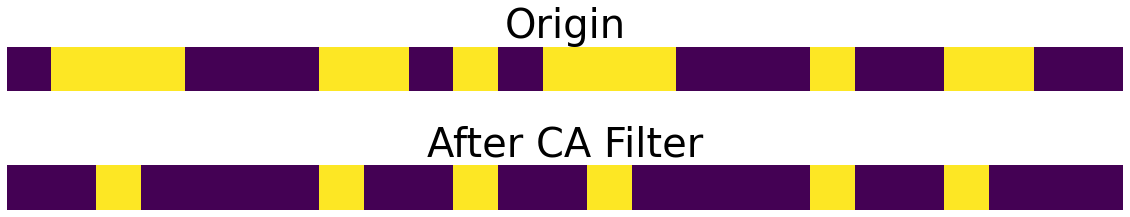

In [18]:
x = np.array([0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,0,0,1,1,0,0])

plt.figure(figsize = (20, 4))
plt.subplot(2,1,1)
plt.imshow(np.matrix(x))
plt.axis('off')
plt.title('Origin',fontsize = 40)

plt.subplot(2,1,2)
plt.imshow(np.matrix(CA(x)))
plt.axis('off')
plt.title('After CA Filter',fontsize = 40)
plt.show()
del x

可以发现分拣效果达到了。

注意到一个问题：如果在均值过滤时遇到这样的“污渍”情况：

$$
\begin{matrix}

\ddots \\
\dots & 0 & 0 & 1 & \dots \\
\dots & 1 & 1 & 0 & \dots \\
\dots & 0 & 0 & 0 &\dots \\
& & & &\ddots

\end{matrix}
$$

会发现单独使用均值过滤(mean filter))是没有办法过滤掉的,但是如果我们对其行、列各使用一次元胞自动分拣机过滤，则会让它先变为：

$$
\begin{matrix}

\ddots \\
\dots & 0 & 0 & 1 & \dots \\
\dots & 1 & 0 & 0 & \dots \\
\dots & 0 & 0 & 0 &\dots \\
& & & &\ddots

\end{matrix}
$$

这个时候再运用一次均值过滤，就可以达到“去除污渍”的效果。所以在正式使用的时候，我们应当使用“一次CA，一次mean”的过滤方式。由于均值过滤对图像本身是有损害的，无数次均值过滤会把画面清空，不能像CA一样具有稳定性，所以对均值过滤的调用要慎重。

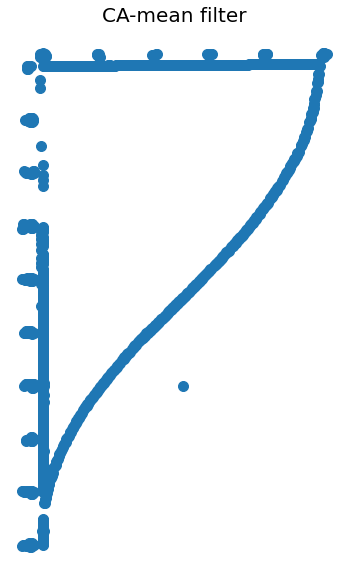

In [19]:
xiyj = get_xiyj(CAfilter(mean_filter(binary) , M0 , N0)) #运用了一次元胞自动分拣机过滤法
plt.figure(figsize = (6,10))
plt.scatter(xiyj[0] , xiyj[1],s = 100)
plt.axis('off')
plt.title('CA-mean filter' , fontsize = 20)
plt.show()

---

## 1.4. 转换矩阵

原理在之前的理论分析中已经详述：

$$
\boldsymbol{X}=\boldsymbol{Q} \boldsymbol{I} + \boldsymbol{X_0}
$$

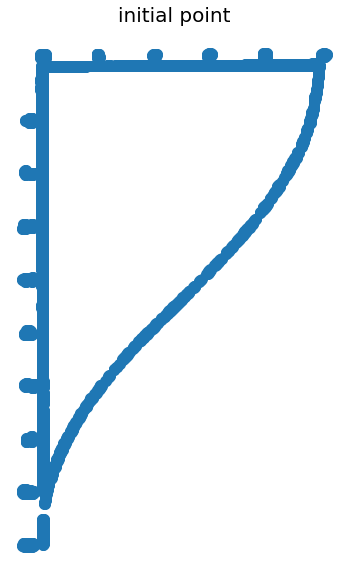

In [20]:
filter0 = mean_filter(mean_filter(binary))
xiyj = get_xiyj(filter0)
plt.figure(figsize = (6,10))
plt.scatter(xiyj[0] , xiyj[1],s = 100)
plt.axis('off')
plt.title('initial point' , fontsize = 20)
plt.show()

容易发现：有这些点是对应的——

| (i,j) | (x,y) |
| - | - |
| (N0,M0) | (0,0) |
| (403,663) | (1,0) |
| (46,17) | (0,90) |

**这里需要注意的是，不要写错i和j的位置！！！**

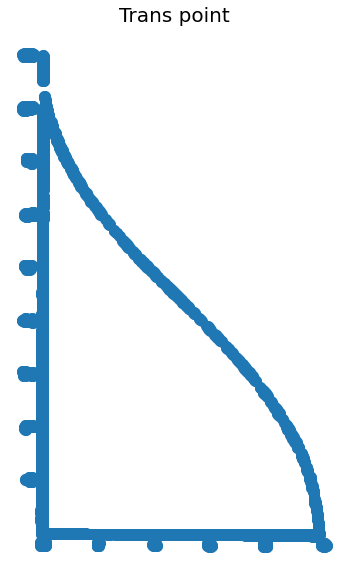

In [21]:
ij_s = np.array([N0,M0,403,663,46,17])
xy_s = np.array([0,0,1,0,0,90])
q , xy0 = Trans(ij_s , xy_s)
del ij_s , xy_s
xy = q.dot(xiyj) + xy0
plt.figure(figsize = (6,10))
plt.scatter(xy[0] , xy[1],s = 100)
plt.axis('off')
plt.title('Trans point' , fontsize = 20)
plt.show()

在上面的图线中，实现了从“像素坐标”到“曲线坐标”的矩阵转换。下面需要抠去坐标轴，以牺牲坐标轴临近点的代价扣去：

In [22]:
#抠去坐标轴,以 xl 和 yl 为下分界点
def rid_axis(xy,xl=0,yl=0):
    x = []
    y = []
    m , n = xy.shape
    for i in range(n):
        if xy[0][i] > xl and xy[1][i] > yl:
            x.append(xy[0][i])
            y.append(xy[1][i])
            pass
        pass
    x = np.array(x)
    y = np.array(y)
    xy_ = np.c_[x,y]
    return xy_.T
    pass

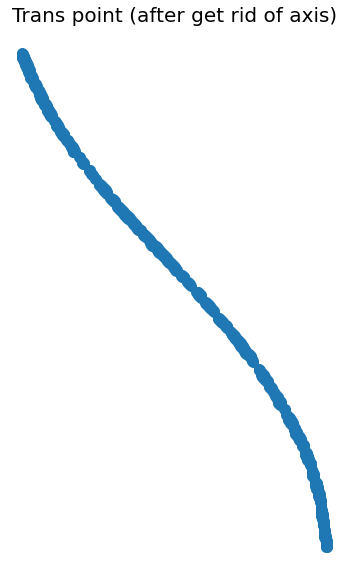

In [23]:
xy = rid_axis(xy,0.05,0.5)
plt.figure(figsize = (6,10))
plt.scatter(xy[0] , xy[1],s = 100)
plt.axis('off')
plt.title('Trans point (after get rid of axis)' , fontsize = 20)
plt.show()

---

## 1.5. 排序去重

因为在提取点的过程中，我们可能没有按照顺序进行提取——因此在最后需要把x按照升序进行排列，为后续的插值做铺垫。

简单讲，我们需要把现在暂存在xy中的数据对，以x为基准进行升序处理——我们采用了冒泡排序法，具体方法函数如下：

In [24]:
#二维的冒泡排序
def sort2(x,y):
    N = x.size
    for i in range(N):
        for j in range(1,N-i):
            if x[j] < x[j-1]:
                x[j-1],x[j] = x[j],x[j-1]
                y[j-1],y[j] = y[j],y[j-1]
                pass
            else:
                pass
            pass
        pass
    pass

#去重
def dup2(x,y):
    xd = list()
    yd = list()
    N = x.size
    for i in range(N):
        item = x[i]
        if item in xd:
            continue
        else:
            tmp = list()
            for j in range(i,N):
                if item == x[j]:
                    tmp.append(y[j])
                    pass
                pass
            tmp = np.array(tmp)
            xd.append(item)
            yd.append(np.mean(tmp))
            pass
        pass
    xd = np.array(xd)
    yd = np.array(yd)
    return xd , yd
    pass

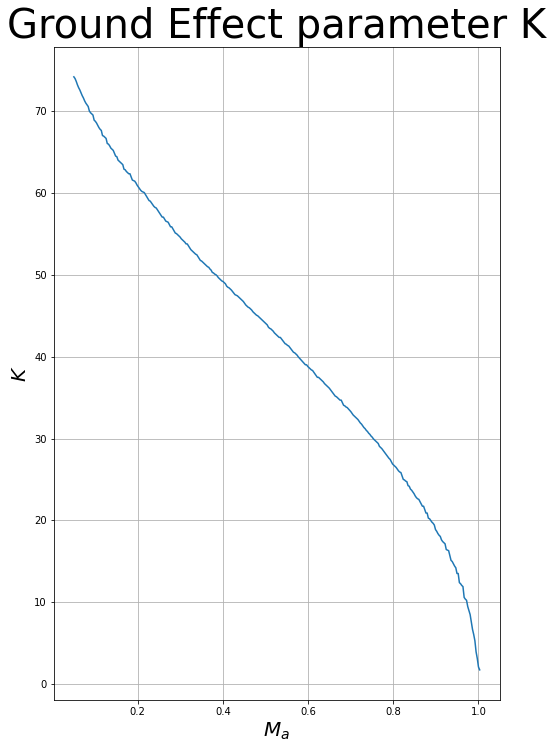

In [25]:
x = xy[0]
y = xy[1]
sort2(x,y)
x,y = dup2(x,y)

plt.figure(figsize=(8,12))
plt.plot(x,y)
plt.grid('on')
plt.xlabel('$M_a$',fontsize = 20)
plt.ylabel('$K$',fontsize = 20)
plt.title('Ground Effect parameter K',fontsize = 40)
plt.show()
del M0 , N0 , binary , filter0 , gray , mat , pic , q, xiyj , xy , xy0

---

---


# 2.Sqlite3数据库的交互访问

SQLite3 可使用 sqlite3 模块与 Python 进行集成。sqlite3 模块是由 Gerhard Haring 编写的。它提供了一个与 PEP 249 描述的 DB-API 2.0 规范兼容的 SQL 接口。不需要单独安装该模块，因为 Python 2.5.x 以上版本默认自带了该模块。

---

## 2.1. 交互展示
为了使用 sqlite3 模块，首先必须创建一个表示数据库的连接对象，然后可以有选择地创建光标对象，这将帮助执行所有的 SQL 语句。

现在jupyternote中没用的变量已经删去，剩下的仅有一组$x,y$存储在RAM中——数据库所要进行的工作就是把上述存储在RAM中的曲线读取的离散点存储进磁盘里，然后在下次需要用到的时候即时调用出来。

In [26]:
import sqlite3 as sq #导入sqlite3模块
! rm ADP.db #运用python与bash交互的特性，删除目录下可能已经创建的数据库
'''
需要注意的是,在windows平台下，这行命令应该被替换为：
! del ADP.db

由于撰写者是在wsl2环境下编写的，所以这里采用linux下的命令
在Windows平台下运行此笔记本的使用者请注意更改！
'''

'\n需要注意的是,在windows平台下，这行命令应该被替换为：\n! del ADP.db\n\n由于撰写者是在wsl2环境下编写的，所以这里采用linux下的命令\n在Windows平台下运行此笔记本的使用者请注意更改！\n'

In [27]:
con = sq.connect('ADP.db') #Aerodynamics Parameters数据库
cur = con.cursor() #创建光标用以操作
cur.execute("\
    create table GroundEffect(\
        x double UNIQUE primary key,\
            y double\
                );")
# 执行——创建表,声明主值 x ，和 y 为double类型
print('successfully create Aerodynamics Parameters Database')
print('successfully create table GroundEffect')

successfully create Aerodynamics Parameters Database
successfully create table GroundEffect


然后将当前jupyter的RAM中的x,y值写入TABLE GrouneEffect中：

In [28]:
for i in range(x.size):
    data = str(x[i]) + ',' + str(y[i]) #生成行数据
    cur.execute('INSERT INTO GroundEffect VALUES (%s)'%data) #塞入 INSERT 行的值
    pass
con.commit() #提交修改
con.close()
del con , cur , data , i , x , y #清除当前RAM里所有变量

不难发现当前的RAM中已经不存在任何变量，但是目录下生成了一个“ADP.db”的文件。于是当我们想要获取数据信息的时候，需要在目录下读取数据库里保存的值——操作如下：

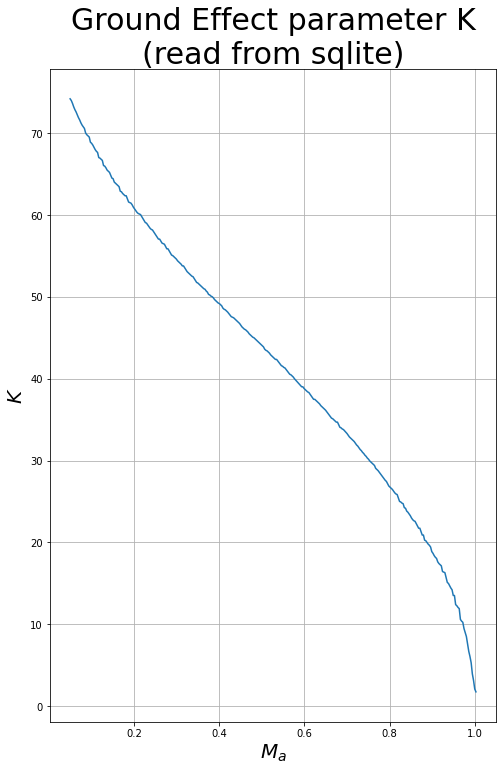

In [29]:
con = sq.connect('ADP.db') #建立连接
cur = con.cursor() #创建光标用以操作
Data = cur.execute("Select x , y from GroundEffect")

x = []
y = []
for row in Data:
    x.append(row[0])
    y.append(row[1])
    pass
x = np.array(x)
y = np.array(y)
plt.figure(figsize=(8,12))
plt.plot(x,y)
plt.grid('on')
plt.xlabel('$M_a$',fontsize = 20)
plt.ylabel('$K$',fontsize = 20)
plt.title('Ground Effect parameter K\n(read from sqlite)',fontsize = 30)
plt.show()
del con , cur , Data , row 

---

## 2.2. 流程化函数

为了简化上述代码过程，我们决定写两个流程化的函数来方便写入与读取。

需要注意的是，为了保证整个jupyternote能正常工作，而不用在乎当前目录下是否已经有建好的数据库，我们利用了python能与bash命令行交互的新特性用以预先清除可能冲突的数据库。已知现在内存RAM中有x,y的原始数据，第一步先清除当前目录下可能存在的数据库文件。

python删除当前目录下文件的命令：
```python
! rm 文件名
```

在windows平台下执行这个操作应该使用：
```python
! del 文件名
```

In [30]:
! rm ADP.db #清除当前目录下的数据库文件

In [31]:
#把x,y写入‘DbName’数据库的‘TableName’表格里
def writeSQL(x,y,DbName,TableName):
    con = sq.connect(DbName+'.db')
    cur = con.cursor()
    command = "create table " + TableName + \
        "(x double UNIQUE primary key,y double);"
    cur.execute(command)
    print('successfully create ' + DbName)
    print('successfully create ' + TableName)
    for i in range(x.size):
        data = str(x[i]) + ',' + str(y[i]) #生成行数据
        cur.execute(('INSERT INTO ' + TableName + ' VALUES (%s)')%data) #塞入 INSERT 行的值
        pass
    con.commit() #提交修改
    con.close()
    pass

#从‘DbName’数据库的‘TableName’表格里，读出x,y数据
def readSQL(DbName,TableName):
    con = sq.connect(DbName+'.db')
    cur = con.cursor()
    Data = cur.execute("Select x , y from " + TableName)
    x = []
    y = []
    for row in Data:
        x.append(row[0])
        y.append(row[1])
        pass
    x = np.array(x)
    y = np.array(y)
    con.close()
    return x , y
    pass

针对上述两个流程——写入和读出，我们将先存在RAM中的x,y做一个数据测试，如下：

successfully create ADP
successfully create GroundEffect


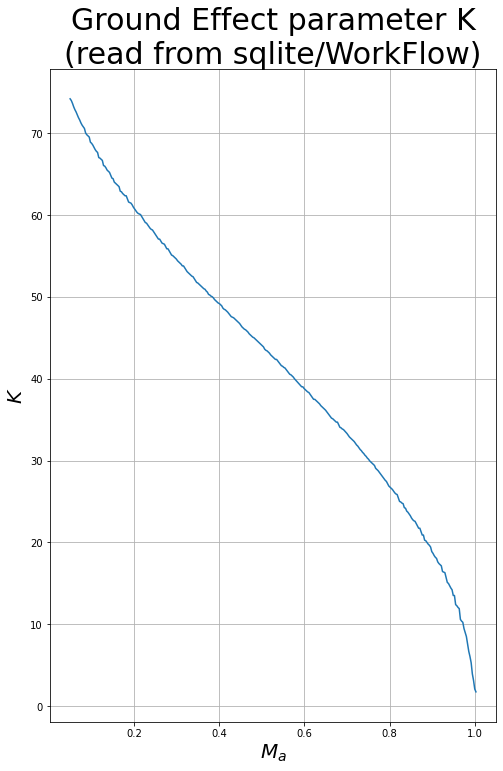

In [32]:
DbName = 'ADP'
TableName = 'GroundEffect'
writeSQL(x , y , DbName , TableName)
del x , y
x , y = readSQL(DbName , TableName)
plt.figure(figsize=(8,12))
plt.plot(x,y)
plt.grid('on')
plt.xlabel('$M_a$',fontsize = 20)
plt.ylabel('$K$',fontsize = 20)
plt.title('Ground Effect parameter K\n(read from sqlite/WorkFlow)',fontsize = 30)
plt.show()
del DbName , TableName

工作流程正常，因此认为编写的与sqlite3交互的代码段是可行的。

---

# 3. 离散数据点的插值连续化分析

虽说完成了离散点的读取，也存入了数据库可供调用——但是输入值基本不可能正好等于已经录入的值。

也就是说对于某一个$x_{in}$，其在数据库中必然不肯能有对应的$y_{out}$，因此我们需要对离散的值进行连续化处理。这就涉及到了我们下一个步骤——插值连续化。

---

## 3.1. 多项式拟合原理

考虑$y=P_n(x)$，其中
$$
P_n(x)=\sum_{i=0}^n a_i x^i=a_0+a_1 x+a_2 x^2+\dots+a_n x^n
$$

那么对于给定的一组序列如下：
| $x_0$ | $x_1$ | ... | $x_n$ |
| - | - | - | - |
| $y_0$ | $y_1$ | ... | $y_n$ |

可知对于任意一个序号$i=0,1,2,3\dots,n$都有：
$$
y_i=a_0+a_1 x_i+a_2 x_i^2\dots a_n x_i^n
$$

写成矩阵形式会有：

$$
\begin{bmatrix}
y_0\\
y_1\\
\vdots\\
y_n
\end{bmatrix}_{n+1}

=

\begin{bmatrix}
1 & x_0 & x_0^2 & \dots & x_0^n\\
1 & x_1 & x_1^2 & \dots & x_1^n\\
\vdots & \vdots & \vdots & \ddots &\vdots\\
1 & x_n & x_n^2 & \dots & x_n^n
\end{bmatrix}_{(n+1)\times (n+1)}

\begin{bmatrix}
a_0\\
a_1\\
\vdots\\
a_n
\end{bmatrix}_{n+1}
$$

于是记
$$

\begin{aligned}
\boldsymbol{X}&=\begin{bmatrix}
1 & x_0 & x_0^2 & \dots & x_0^n\\
1 & x_1 & x_1^2 & \dots & x_1^n\\
\vdots & \vdots & \vdots & \ddots &\vdots\\
1 & x_n & x_n^2 & \dots & x_n^n
\end{bmatrix}

\\
\\

\boldsymbol{Y}&=\begin{bmatrix}
y_0\\
y_1\\
\vdots\\
y_n
\end{bmatrix}

\\
\\

\boldsymbol{A}&=\begin{bmatrix}
a_0\\
a_1\\
\vdots\\
a_n
\end{bmatrix}
\end{aligned}
$$

于是可以得到：

$$
\boldsymbol{X}^{-1}\boldsymbol{Y}=\boldsymbol{A}
$$

整个求解过程可以参考如下代码。

In [33]:
#给出x数列，生成大X矩阵
def getX(x):
    n = x.size
    X = np.zeros([n,n])
    for i in range(n):
        X[i] = x**i
        pass
    return X.T
    pass

#输入对应的一组 x,y ，根据其数据规模，返回对应的稀疏矩阵A
def PnFitted(x,y):
    n = x.size
    X = getX(x)
    A = np.linalg.inv(X).dot(y)
    return A
    pass

例如，我们给出这样一个函数：

$$
y=7x^3+5x^2+\frac{x}{2}+1
$$

给出$x=1,2,3,4$时候，y对应的输出

| var | 1 | 2 | 3 | 4 |
| - | - | - | - | - |
| x | 1 | 2 | 3 | 4 |
| y | 13.5 | 78 | 236.5 | 531 |

In [34]:
x1 = np.array([1,2,3,4])
y1 = 7*x1**3+5*x1**2+x1/2+1
a = PnFitted(x1,y1)
print('拟合系数数列为\n',a)
del x1 , y1 , a

拟合系数数列为
 [1.  0.5 5.  7. ]


## 3.2. 插值原理

对于已知$x_i,x_{i+1},y_i,y_{i+1}$的情况，若有$x_i<x<x_{i+1}$，则可以使用近似的线性插值：

$$
y=\frac{x_{i+1}-x}{x_{i+1}-x_i}\cdot x_i+\frac{x-x_i}{x_{i+1}-x_i}\cdot x_{i+1}
$$

如果给定的情况能够包含$i-1,i,i+1$则可以使用二次拟合，给定的越多越能用高次多项式拟合。

但事实上，如果给的点太多，反而会因为“过拟合”导致结果偏差太大，效果甚至不如线性插值更精确。

另外对于不在给定范围内的情况，如$x<x_0$或者$x>x_n$，则可以$x_0,x_1,x_2$进行二次拟合，运用“外拓”的想法求得，但精度不能保证，这点在wolfram语言中有所体现。

那么我们在实际操作中，使用二次拟合——这样一来可以避免线性插值带来的不精确，也能满足一定的运算速度需求。

In [35]:
def Interpoly(xin,x,y):
    if xin in x:
        k = np.argwhere(x == xin)
        return y[k]
    elif xin < x[1]:
        xx = np.array([
            x[0],x[1],x[2]
        ])
        yy = np.array([
            y[0],y[1],y[2]
        ])
        a=PnFitted(xx,yy)
        return a[0] + a[1] * xin + a[2] * xin**2
    elif xin > x[-2]:
        xx = np.array([
            x[-1],x[-2],x[-3]
        ])
        yy = np.array([
            y[-1],y[-2],y[-3]
        ])
        a = PnFitted(xx,yy)
        return a[0] + a[1] * xin + a[2] * xin**2
    else:
        k = 0
        while x[k] < xin:
            k+= 1
            pass
        xx = np.array([
            x[k-1],x[k],x[k+1]
        ])
        yy = np.array([
            y[k-1],y[k],y[k+1]
        ])
        a = PnFitted(xx,yy)
        return a[0] + a[1] * xin + a[2] * xin**2
    pass

我们不妨取
$$
y=\sin x
$$
的图像做一个演示，将步长为1、从0到10的数据作为插值原始数据，绘制图像：

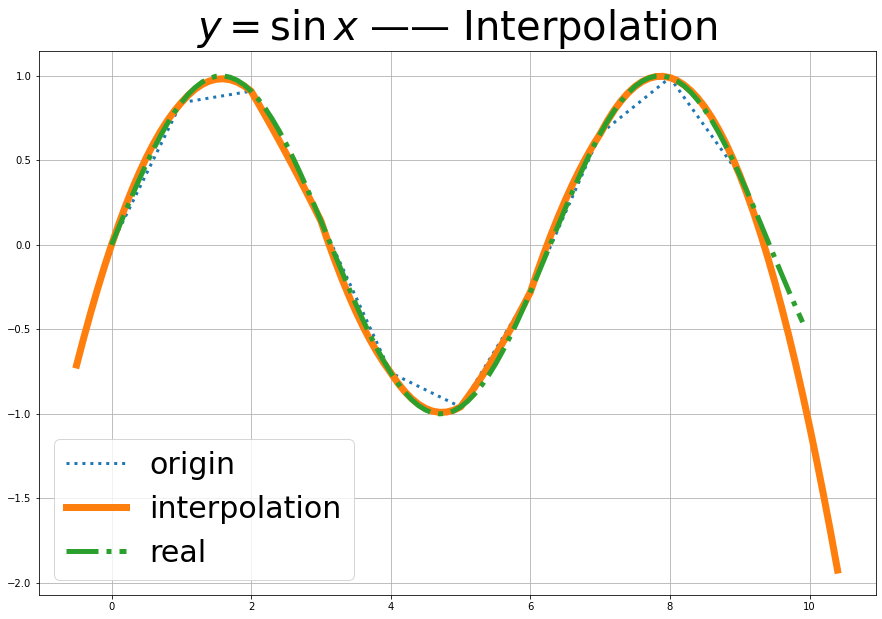

In [36]:
x1 = np.arange(0,10,1)
y1 = np.sin(x1)
plt.figure(figsize=(15,10))
plt.plot(x1,y1,label='origin' , linestyle = ':', linewidth = 3)
xx=np.arange(-0.5,10.5,0.1)
yy=np.zeros(xx.size)
for i in range(xx.size):
    yy[i] = Interpoly(xx[i],x1,y1)
    pass
plt.plot(xx,yy,label='interpolation' , linewidth = 7)
x2 = np.arange(0,10,0.1)
y2 = np.sin(x2)
plt.plot(x2,y2,label = 'real' , linestyle = '-.' , linewidth = 5)
plt.legend(fontsize=30)
plt.grid(True)
plt.title('$y=\sin x$ —— Interpolation',fontsize = 40)
plt.show()
del x1 , y1 , x2 , y2 , xx , yy , i

可以发现，二次插值拟合的效果要比线性拟合(既原始图像)要更贴近于原图，拟合效果好得多。那么对于我们例子中，可以生成一个函数用以即时与sqlite3交互得到离散值，并返回拟合值，如下所示：

In [37]:
def GroundEffectK(xin):
    x , y = readSQL('ADP','GroundEffect')
    return Interpoly(xin,x,y)
    pass

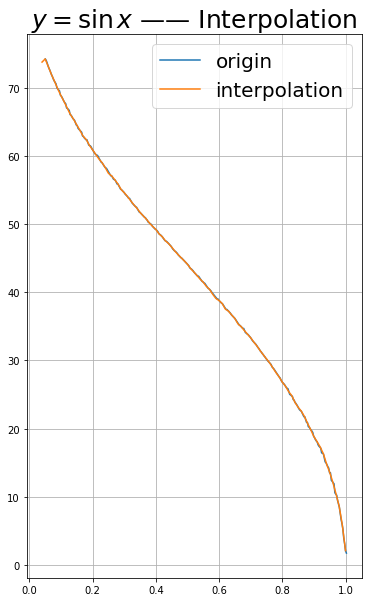

In [38]:
plt.figure(figsize = (6,10))
plt.plot(x,y,label = 'origin')
xx = np.arange(0.04,1.01,0.01)
yy=np.zeros(xx.size)
for i in range(xx.size):
    yy[i] = GroundEffectK(xx[i])
    pass
plt.plot(xx,yy,label = 'interpolation')
plt.legend(fontsize = 20)
plt.grid(True)
plt.title('$y=\sin x$ —— Interpolation',fontsize = 25)
plt.show()
del i , x , y , xx , yy

可以发现二次的插值拟合在整个曲线域上的插值拟合效果是非常优秀的，我们根据原始插值函数'Interpolation'和数据库交互函数'readSQL'两者结合编写的'GroundEffect'函数有着不错的精度和运算效率，符合了气动数据库建立的要求。

---

---

# 4. 打包模块实例展示

在进行上述操作的过程中，对不同的图线，很多操作都是重复的——为了进行代码重用以及操作流程化，我们考虑将上述函数进行整合并写入一个模块“ADP.py”，意为“AeroDynamics Parameter”python模块文件。我们在考虑这个模块写法的时候，主要思考了两个方向：

- 流程的通式化
- 图象的特殊性

不可否认的是，我们都希望输入一张图片，输出立刻就能生成一个对应的函数映射关系；但是受制于影印版数据图象文件各有不同，不可能寻找到一个通用的方式来处理每一个图片文件，所以这个时候用class封装会显得有些笨拙——面向对象的编程往往需要高度抽象性和一致性，这两个特性是OOP比较难以完成的。

流程的通式化与图像的特殊性本就是不可调和的一对矛盾关系，所以我们用面向过程的思考方式，给用户足够的调试可能；同时用class类管理图像数据，完成小部分的通式化流程——而更多的可能则交给调用这个模块的使用者。

我们以书本中某一条图线为例子说明。

In [39]:
import ADP as ad #导入库

---

## 4.1. Pic对象创建
第一段代码只需要执行：

```python
a = ad.Pic(PictureName,up)
```

PictureName为图片名字，这是字符串；

up为人工二值化函数里选取的界限，默认为4;

这一步处理后，Pic对象内有如下变量：

- name 图像名字
- pic 原图矩阵
- gray 灰度矩阵
- binary 灰度化矩阵
- M0,N0 原点像素坐标

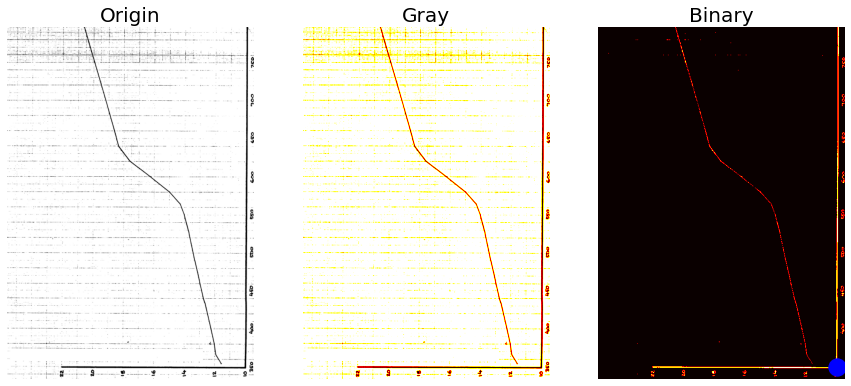

In [40]:
name = 'ex4.png' # 给出文件名
ex4 = ad.Pic(name , up=5) # 创建Pic图像类别,人工二值化分界点up=5

#展示图象 
#下面这段代码只是为了展示Pic创建效果，不是务必执行
plt.figure(figsize = (15,9))

plt.subplot(1,3,1)
plt.imshow(ex4.pic)
plt.axis('off')
plt.title('Origin',fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(ex4.gray , cmap = plt.cm.hot)
plt.axis('off')
plt.title('Gray',fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(ex4.binary , cmap = plt.cm.hot)
plt.axis('off')
plt.title('Binary',fontsize = 20)
plt.scatter(ex4.N0 , ex4.M0 , color = 'b' , s = 300)

plt.show()

---

## 4.2. 过滤操作

在做完了初始化后，我们下面需要进行过滤操作。过滤函数为：

```python
a.Filter(way,limit)
```

其中way是指过滤方式为字符串，m或M表示均值过滤(mean filter),c或C表示元胞自动分拣机过滤；按顺序过滤。如'mcm'表示一次均值、一次元胞、再一次均值的过滤步骤；默认值为'mc'。

limit则是均值过滤的分界线，默认取为0.34。

运行结束后，self中多了：

- fil 过滤后的矩阵
- xiyj 过滤后的点坐标

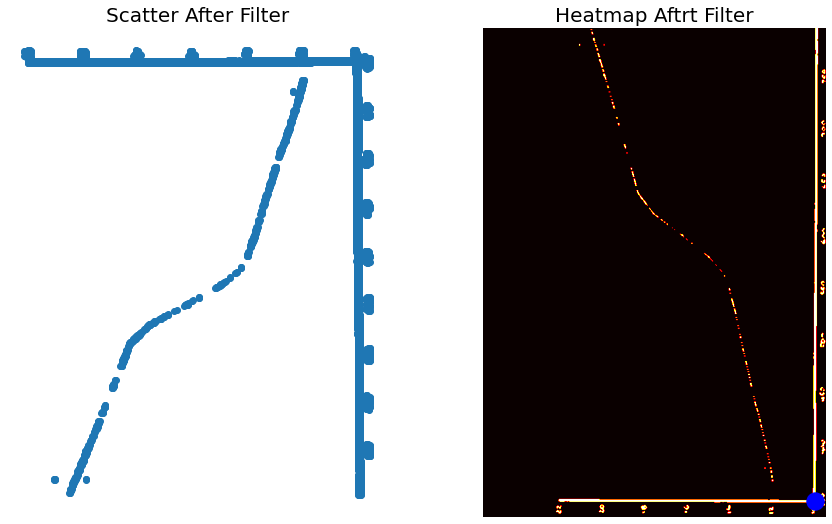

In [41]:
ex4.Filter('m' , 0.3) #一次均值过滤，过滤分界点0.33

#显示图像，可以不执行
plt.figure(figsize = (15,9))

plt.subplot(1,2,1)
plt.scatter(ex4.xiyj[0] , ex4.xiyj[1])
plt.axis('off')
plt.title('Scatter After Filter',fontsize = 20)

plt.subplot(1,2,2)
plt.imshow(ex4.fil , cmap = plt.cm.hot)
plt.axis('off')
plt.title('Heatmap Aftrt Filter',fontsize = 20)
plt.scatter(ex4.N0 , ex4.M0 , color = 'b' , s = 300)

plt.show()

---

## 4.3. 坐标变换以及转换矩阵

再观察数据之后，可以发现有以下几个对应点：

- (784,550)->(350,10)
- (784,125)->(350,22)
- (0,552)->(800,10)

在Pic类里面，提供了set_p1,2,3()函数，用以设置对应关系，和get_Trans()函数用以坐标变换，如

```python
a.set_p1(x1,y1,j1,i1)
a.set_p2(x2,y2,j2,i2)
a.set_p3(x3,y3,j3,i3)
a.get_Trans()
```

**需要注意的是，这里j和i的录入顺序不要弄错**，另外set_p1()函数可以只给x1，y1，默认的j1=M0，i1=N0。

这步结束以后，self中多了：
- q 转换矩阵
- xy0 转换零点坐标
- xy_init 未抠去坐标轴的曲线坐标系下的点集

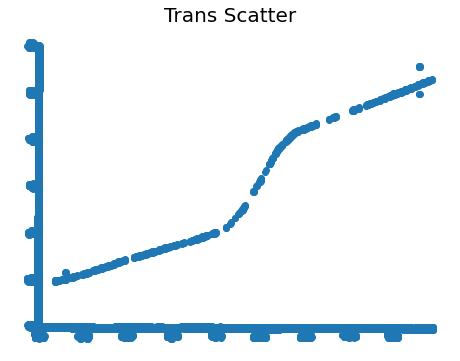

In [42]:
ex4.set_p1(350,10)
ex4.set_p2(350,22,784,125)
ex4.set_p3(800,10,0,552)
ex4.get_Trans()

#只展示xy_init
plt.figure(figsize= (8,6))
plt.scatter(ex4.xy_init[0] , ex4.xy_init[1])
plt.axis('off')
plt.title('Trans Scatter',fontsize = 20)

plt.show()

---

## 4.4. 抠去坐标轴以及排序、去重、获得值

使用

```python
a.process(xl,yl)
```
其中xl，yl控制坐标轴抠去的部分，运行结束后，self中多了：
- xy 第一行为x值，第二行为y值

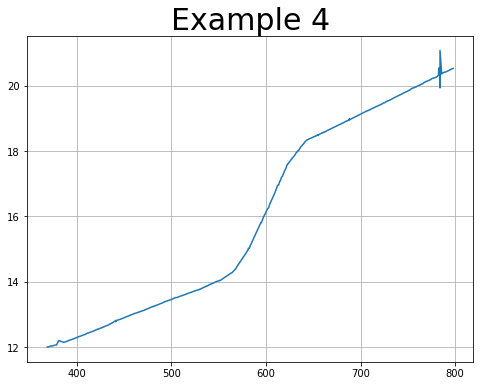

In [43]:
ex4.process(360,10.5)

#下面是可视化绘图
plt.figure(figsize= (8,6))
plt.title('Example 4',fontsize = 30)
plt.plot(ex4.xy[0],ex4.xy[1])
plt.grid(True)
plt.show()

--- 

## 4.5. 数据库交互

执行如下程序

```python
ad.writeSQL(a.xy[0],a.xy[1],DbName,TableName) #写入
x ,y = ad.readSQL(DbName,TableName) #读取
```

successfully create ADP
successfully create EX4


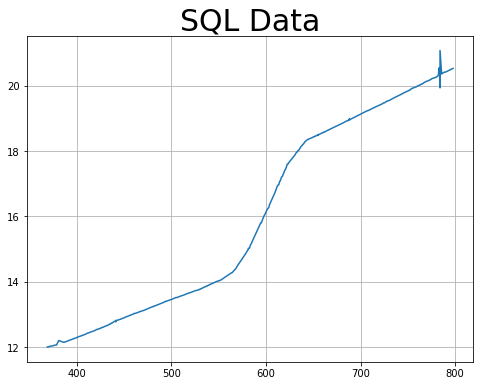

In [44]:
ad.writeSQL(ex4.xy[0],ex4.xy[1],'ADP','EX4')

del name , ex4

x ,  y = readSQL('ADP','EX4')

plt.figure(figsize= (8,6))
plt.title('SQL Data',fontsize = 30)
plt.plot(x,y)
plt.grid(True)
plt.show()

---

## 4.6. 插值连续化函数构造

运用Interpoly函数构造生成函数。
```python
def func_a(xin):
    x , y = ad.readSQL(DbName,TableName)
    return ad.Interpoly(xin,x,y)
    pass
```

这里为了解决数组循环重复链接数据库导致的性能损失，做一个数据类型判定，如下：

In [45]:
def func_ex4(xin):
    x , y =ad.readSQL('ADP','EX4')
    if type(xin) == np.ndarray:
        tmp = np.zeros(xin.shape)
        for i in range(tmp.size):
            tmp[i] = ad.Interpoly(xin[i],x,y)
            pass
        return tmp
        pass
    else:
        return ad.Interpoly(xin,x,y)
        pass
    pass

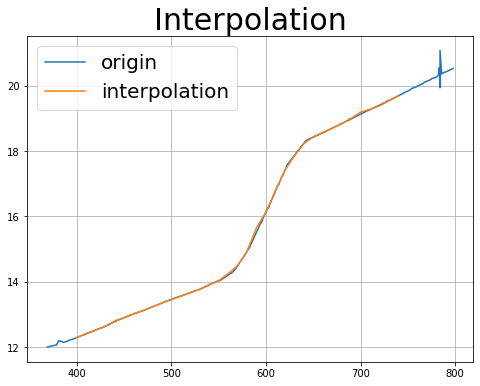

In [46]:
xx = np.arange(400,750,10)
yy = func_ex4(xx)

#作图
plt.figure(figsize= (8,6))
plt.title('Interpolation',fontsize = 30)
plt.plot(x,y,label = 'origin')
plt.plot(xx,yy,label = 'interpolation')
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

---

这就是我们组写的ADP.py的所有用法示例，可以发现效果对要求的符合是可行的。

- 011810412 周长威
- 011810422 包晨宇
- 011810716 吴哲铭
- 021820218 胡天辰
- 051810313 孙赵轩

<div align="center"><img src="https://cdn.jsdelivr.net/gh/bcynuaa/learning@main/project/Flight%20Simulation/homework/lena.jpg" width=60%></div>
<div align="center"><font size=50>Thanks For Watching</font></div>